# # Exploratory Data Analysis Part-2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
final_df=pd.read_parquet('final_data.parquet')
final_df.shape

(17311807, 32)

### Strategic Customer & Financial Insights

#### Delivery Experience Impact on Next Purchase Value

In [7]:
final_df = final_df.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

final_df['order_delivered_customer_date'] = pd.to_datetime(final_df['order_delivered_customer_date'])
final_df['order_estimated_delivery_date'] = pd.to_datetime(final_df['order_estimated_delivery_date'])


final_df['is_late']=(final_df['order_delivered_customer_date']>final_df['order_estimated_delivery_date']).astype(int)

final_df['revenue'] = final_df['price'] + final_df['freight_value']

final_df['previous_order_late'] = final_df.groupby('customer_unique_id')['is_late'].shift(1)
impact_analysis = final_df.groupby('previous_order_late')['revenue'].mean()
print("\n--- Average Revenue of Next Purchase (Based on Previous Delivery) ---")
print(impact_analysis)


--- Average Revenue of Next Purchase (Based on Previous Delivery) ---
previous_order_late
0.0    139.003958
1.0    155.467629
Name: revenue, dtype: float64


#### "Silent Churn" Identification

In [ ]:
final_df['order_purchase_timestamp'] = pd.to_datetime(final_df['order_purchase_timestamp'])

final_df = final_df.sort_values(by=['customer_unique_id','order_purchase_timestamp'])
final_df['time_since_last_purchase']=final_df.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

customer_summary=final_df.groupby('customer_unique_id').agg(
    last_purchase=('order_purchase_timestamp', 'max'),
    avg_repurchase_time=('time_since_last_purchase', 'mean'),
    frequency=('order_id', 'nunique')
)
customer_summary=customer_summary[customer_summary['frequency']>2].copy() # Focus on frequent buyers
customer_summary['days_since_last_purchase']=(final_df['order_purchase_timestamp'].max()-customer_summary['last_purchase']).dt.days
customer_summary['churn_risk_factor']=customer_summary['days_since_last_purchase']/customer_summary['avg_repurchase_time']
at_risk_of_churn=customer_summary[customer_summary['churn_risk_factor']>3]
print(f"\nFound {len(at_risk_of_churn)} high-value customers at risk of silent churn.")


Found 212 high-value customers at risk of silent churn.


### Advanced Financial & Strategic Insights

#### "Return on Freight" Analysis

In [10]:
# --- Return on Freight ---
final_df['profit_proxy'] = final_df['price'] - final_df['freight_value']
final_df['return_on_freight'] = final_df['profit_proxy'] / final_df['freight_value']
high_freight_orders = final_df[final_df['freight_value'] > final_df['freight_value'].quantile(0.75)]
print(f"Average 'Return on Freight' for high-cost shipping orders: {high_freight_orders['return_on_freight'].mean():.2f}")

Average 'Return on Freight' for high-cost shipping orders: 5.58


#### Price Elasticity Proxy (by Seller)

In [ ]:
category_avg_price = final_df.groupby('product_category_name_english')['price'].transform('mean')
final_df['price_vs_avg'] = final_df['price'] / category_avg_price
seller_pricing_strategy = final_df.groupby('seller_id').agg(
    avg_price_ratio=('price_vs_avg', 'mean'),
    total_orders=('order_id', 'nunique')
)
print("\n--- Correlation between Pricing Strategy and Order Volume ---")
print(seller_pricing_strategy.corr())


--- Correlation between Pricing Strategy and Order Volume ---
                 avg_price_ratio  total_orders
avg_price_ratio         1.000000     -0.048313
total_orders           -0.048313      1.000000


#### Customer Lifetime Value (CLV) to Customer Acquisition Cost (CAC) Ratio (Proxy)

In [ ]:
clv = final_df.groupby('customer_unique_id')['revenue'].sum()
first_purchase_df = final_df.drop_duplicates('customer_unique_id', keep='first')
avg_cac_proxy = first_purchase_df['freight_value'].mean()
ltv_to_cac_ratio = clv.mean() / avg_cac_proxy
print(f"\nEstimated LTV to CAC Ratio is: {ltv_to_cac_ratio:.2f} : 1")


Estimated LTV to CAC Ratio is: 1316.86 : 1


#### "Gateway Product" Financial Impact

In [17]:
# --- Gateway Product Financial Impact ---
first_purchase_df = final_df.sort_values('order_purchase_timestamp').drop_duplicates('customer_unique_id', keep='first')
customer_clv = final_df.groupby('customer_unique_id')['revenue'].sum().reset_index()
gateway_impact = pd.merge(first_purchase_df[['customer_unique_id', 'product_category_name_english']], customer_clv, on='customer_unique_id')
avg_clv_by_gateway = gateway_impact.groupby('product_category_name_english')['revenue'].mean().sort_values(ascending=False)
print("\n--- Average Customer Lifetime Value by First Purchase Category ---")
print(avg_clv_by_gateway.head(5))


--- Average Customer Lifetime Value by First Purchase Category ---
product_category_name_english
computers                                204941.589588
small_appliances_home_oven_and_coffee    120463.813056
home_appliances_2                        100440.450046
agro_industry_and_commerce                89042.211782
small_appliances                          61844.347986
Name: revenue, dtype: float64


### Advanced Customer & Seller Dynamics

#### Customer "Binge Buying" Behavior

In [18]:
df_sorted = final_df.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
df_sorted['time_since_last_purchase_hours'] = df_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.total_seconds() / 3600
binge_buyers = df_sorted[(df_sorted['time_since_last_purchase_hours'] > 0) & (df_sorted['time_since_last_purchase_hours'] < 24)]
print(f"\nFound {len(binge_buyers)} instances of 'binge buying' (next order within 24 hours).")


Found 629 instances of 'binge buying' (next order within 24 hours).


#### Seller Niche Score

In [ ]:
category_popularity = final_df.groupby('product_category_name_english')['seller_id'].nunique()
final_df['category_rarity'] = final_df['product_category_name_english'].map(1 / category_popularity)
seller_niche_score = final_df.groupby('seller_id')['category_rarity'].mean().sort_values(ascending=False)
print("\n--- Top 5 Most 'Niche' Sellers ---")
print(seller_niche_score.head())


--- Top 5 Most 'Niche' Sellers ---
seller_id
d7f1cfc638473be93baedbfd02208016    0.333333
c731d18cea9bf687ffee82a241c25b11    0.303582
05aebce0b5c8f0d41b29b686f2d05fd3    0.224975
191d55f7edb8524d525ed01b20fe32e8    0.200000
bc2ac6b95e1accce9858528ee566c17e    0.166667
Name: category_rarity, dtype: float64


#### Seller Reputation Risk

In [22]:
seller_risk = final_df.groupby('seller_id').agg(
    total_orders=('order_id', 'nunique'),
    late_rate=('is_late', 'mean')
)
high_risk_sellers = seller_risk[seller_risk['total_orders'] > 30].sort_values(by='late_rate', ascending=False)
print("\n--- Top 5 Sellers by Reputation Risk (Late Delivery Rate) ---")
print(high_risk_sellers.head())


--- Top 5 Sellers by Reputation Risk (Late Delivery Rate) ---
                                  total_orders  late_rate
seller_id                                                
54965bbe3e4f07ae045b90b0b8541f52            69   0.365483
432c37c9dfba871172ec162e20118b8c            42   0.335799
ad781527c93d00d89a11eecd9dcad7c1            38   0.331889
ede0c03645598cdfc63ca8237acbe73d            42   0.322955
d93919c944be9cff128f6c9cb899eacb            33   0.302776


#### Customer "Cross-Category" Purchase Behavior

In [24]:
df_sorted = final_df.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
df_sorted['previous_category'] = df_sorted.groupby('customer_unique_id')['product_category_name_english'].shift(1)
cross_sell_matrix = pd.crosstab(df_sorted['previous_category'], df_sorted['product_category_name_english'])
# Example: What do people buy after 'furniture_decor'?
print("\n--- Top 5 Categories Purchased After 'furniture_decor' ---")
print(cross_sell_matrix.loc['furniture_decor'].sort_values(ascending=False).head())


--- Top 5 Categories Purchased After 'furniture_decor' ---
product_category_name_english
furniture_decor    1377824
bed_bath_table          90
housewares              34
garden_tools            22
watches_gifts           14
Name: furniture_decor, dtype: int64


### Granular Logistics & Anomaly Detection

#### "Flash Sale" Impact on Logistics

In [28]:
# Processing time and shipping time in days
final_df['order_delivered_carrier_date'] = pd.to_datetime(final_df['order_delivered_carrier_date'])
final_df['order_approved_at'] = pd.to_datetime(final_df['order_approved_at'])

final_df['proc_time'] = (final_df['order_delivered_carrier_date'] - final_df['order_approved_at']).dt.days
final_df['ship_time'] = (final_df['order_delivered_customer_date'] - final_df['order_delivered_carrier_date']).dt.days

In [29]:
daily_orders = final_df.groupby(final_df['order_purchase_timestamp'].dt.date)['order_id'].nunique()
flash_sale_threshold = daily_orders.quantile(0.99)
flash_sale_days = daily_orders[daily_orders > flash_sale_threshold].index
flash_sale_df = final_df[final_df['order_purchase_timestamp'].dt.date.isin(flash_sale_days)]
print(f"\nAverage processing time on flash sale days: {flash_sale_df['proc_time'].mean():.2f} days")
print(f"Average processing time on normal days: {final_df[~final_df.index.isin(flash_sale_df.index)]['proc_time'].mean():.2f} days")


Average processing time on flash sale days: 3.39 days
Average processing time on normal days: 2.32 days


#### Delivery Time Consistency (Jitter)

In [ ]:
if 'shipping_route' not in final_df.columns:
	final_df['shipping_route'] = (
		final_df['seller_city'].astype(str) + ', ' + final_df['seller_state'].astype(str) +
		' → ' +
		final_df['customer_city'].astype(str) + ', ' + final_df['customer_state'].astype(str)
	)

if 'delivery_time_days' not in final_df.columns:
	final_df['delivery_time_days'] = (
		(final_df['order_delivered_customer_date']-final_df['order_delivered_carrier_date']).dt.days
	)

route_consistency = final_df.groupby('shipping_route')['delivery_time_days'].std().sort_values(ascending=False)
print("\n--- Top 5 Shipping Routes with the Most Inconsistent Delivery Times ---")
print(route_consistency.head())


--- Top 5 Shipping Routes with the Most Inconsistent Delivery Times ---
shipping_route
itaquaquecetuba, SP → teresina, PI            87.378731
sao jose dos campos, SP → santa maria, RS     82.390230
indaiatuba, SP → sao bernardo do campo, SP    79.748937
uberlandia, MG → valenca, BA                  76.579152
maringa, PR → fortaleza, CE                   76.339391
Name: delivery_time_days, dtype: float64


#### Seller City Processing Power

In [ ]:
processing_power = final_df.groupby('seller_city')['order_id'].nunique().sort_values(ascending=False)
print("\n--- Top 5 Seller Cities by Total Orders Processed ---")
print(processing_power.head())


--- Top 5 Seller Cities by Total Orders Processed ---
seller_city
sao paulo         23644
ibitinga           6344
curitiba           2632
santo andre        2611
belo horizonte     2253
Name: order_id, dtype: int64


#### "Shipping Shadow" of Hubs

In [34]:
hub_city = 'sao paulo'
hub_deliveries = final_df[final_df['seller_city'] == hub_city]
shipping_shadow = hub_deliveries.groupby('customer_state')['ship_time'].mean().sort_values()
print(f"\n--- Average Shipping Time from '{hub_city}' to Different States ---")
print(shipping_shadow)


--- Average Shipping Time from 'sao paulo' to Different States ---
customer_state
SP     3.568468
MG     7.318059
PR     8.117061
DF     8.262373
ES     9.942241
GO    10.192495
SC    10.688676
RJ    10.797252
RS    11.031146
TO    11.033046
MS    11.484299
PE    12.642283
MT    13.548829
RN    13.786126
SE    14.524433
PI    14.808318
PB    14.830991
BA    14.842574
MA    14.897691
RO    15.337677
CE    15.714127
RR    17.564780
PA    17.797458
AP    20.211239
AM    20.705539
AL    21.444210
AC    21.509968
Name: ship_time, dtype: float64


#### "Multi-Item Order" Logistics Complexity

In [ ]:
order_item_count = final_df.groupby('order_id')['product_id'].transform('nunique')
final_df['is_multi_item_order'] = order_item_count > 1
complexity_impact = final_df.groupby('is_multi_item_order')[['proc_time', 'ship_time']].mean()
print("\n--- Performance of Single vs. Multi-Item Orders ---")
print(complexity_impact)


--- Performance of Single vs. Multi-Item Orders ---
                     proc_time  ship_time
is_multi_item_order                      
False                 2.374925   8.539044
True                  2.174424   7.460084


#### Seasonal Delivery Performance

In [ ]:
final_df['purchase_quarter'] = final_df['order_purchase_timestamp'].dt.to_period('Q')
seasonal_performance = final_df.groupby('purchase_quarter')['is_late'].mean() * 100
print("--- Late Delivery Rate by Quarter ---")
print(seasonal_performance)

--- Late Delivery Rate by Quarter ---
purchase_quarter
2016Q4     0.417006
2017Q1     3.182839
2017Q2     4.274760
2017Q3     3.298511
2017Q4     9.512664
2018Q1    14.124257
2018Q2     4.217776
2018Q3     6.247382
Freq: Q-DEC, Name: is_late, dtype: float64


#### Freight Cost Anomaly Detection

In [ ]:
from scipy.stats import zscore

if 'product_weight_g' in final_df.columns:
    final_df['freight_per_gram'] = final_df['freight_value'] / final_df['product_weight_g']
    final_df['freight_zscore'] = zscore(final_df['freight_per_gram'].replace([np.inf, -np.inf], np.nan).dropna())
    freight_anomalies = final_df[abs(final_df['freight_zscore']) > 3]
    print(f"\nFound {len(freight_anomalies)} orders with anomalous freight costs.")


Found 16201 orders with anomalous freight costs.


#### Zombie Customer Analysis

In [ ]:
if 'review_score' in final_df.columns:
    customer_summary = final_df.groupby('customer_unique_id').agg(
        last_purchase=('order_purchase_timestamp', 'max'),
        avg_review=('review_score', 'mean')
    )
    good_customers = customer_summary[customer_summary['avg_review'] >= 4]
    six_months_ago = final_df['order_purchase_timestamp'].max() - pd.DateOffset(months=6)
    zombie_customers = good_customers[good_customers['last_purchase'] < six_months_ago]
    print(f"\nFound {len(zombie_customers)} high-satisfaction customers who haven't purchased in over 6 months.")


Found 41461 high-satisfaction customers who haven't purchased in over 6 months.


#### Weekday vs. Weekend Shipping Performance

In [41]:
final_df['carrier_pickup_day']=final_df['order_delivered_carrier_date'].dt.day_name()
weekend_shipping_impact=final_df.groupby('carrier_pickup_day')['ship_time'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
print("\n--- Average Shipping Time by Carrier Pickup Day ---")
print(weekend_shipping_impact)


--- Average Shipping Time by Carrier Pickup Day ---
carrier_pickup_day
Monday        7.799883
Tuesday       8.217913
Wednesday     8.442740
Thursday      8.710480
Friday        9.096590
Saturday     10.795393
Sunday        5.172866
Name: ship_time, dtype: float64


#### Top Customer-Seller Pairs

In [ ]:
customer_seller_pairs = final_df.groupby(['customer_unique_id', 'seller_id']).size().reset_index(name='order_count')
top_pairs = customer_seller_pairs.sort_values(by='order_count', ascending=False)
print("\n--- Top 5 Most Loyal Customer-Seller Pairs ---")
print(top_pairs.head())


--- Top 5 Most Loyal Customer-Seller Pairs ---
                     customer_unique_id                         seller_id  \
78538  d425130be1b15a4580645e4a3c9b4768  98dac6635aee4995d501a3972e047414   
21287  397b44d5bb99eabf54ea9c2b41ebb905  b372ee768ed69e46ca8cdbd267aa7a38   
93668  fd7069cf6891edbf32ba84c9c3f083d4  ccb83a794700270fde70898fe9ff368b   
49804  86bfc49565a9ca52fcbf861fcc1e67a4  aac29b1b99776be73c3049939652091d   
18512  31e412b9fb766b6794724ed17a41dfa6  1f50f920176fa81dab994f9023523100   

       order_count  
78538         8556  
21287         7714  
93668         6876  
49804         6876  
18512         6706  


#### Average Product Price by State

In [ ]:
price_by_state = final_df.groupby('customer_state')['price'].mean().sort_values(ascending=False)
print("\n--- Top 5 States by Average Product Price ---")
print(price_by_state.head())


--- Top 5 States by Average Product Price ---
customer_state
PB    198.697881
AC    198.096273
AL    195.157767
TO    183.222144
AP    178.055180
Name: price, dtype: float64


#### Seller "Ramp-Up" Time (Proxy)

In [ ]:
df_sorted = final_df.sort_values(['seller_id', 'order_purchase_timestamp'])
df_sorted['sale_number'] = df_sorted.groupby('seller_id').cumcount() + 1

seller_first_sale = df_sorted.groupby('seller_id')['order_purchase_timestamp'].transform('min')
df_sorted['seller_first_sale'] = seller_first_sale

tenth_sale_df = df_sorted[df_sorted['sale_number'] == 10]
tenth_sale_df['ramp_up_time'] = (tenth_sale_df['order_purchase_timestamp'] - tenth_sale_df['seller_first_sale']).dt.days
print(f"\nAverage time for a new seller to make 10 sales: {tenth_sale_df['ramp_up_time'].mean():.2f} days.")


Average time for a new seller to make 10 sales: 0.38 days.


C:\Users\mahes\AppData\Local\Temp\ipykernel_32024\3600601922.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tenth_sale_df['ramp_up_time'] = (tenth_sale_df['order_purchase_timestamp'] - tenth_sale_df['seller_first_sale']).dt.days


#### Seller Cannibalization Proxy

In [45]:
seller_city_monthly = final_df.groupby(['seller_city', 'purchase_month'])['order_id'].nunique().reset_index()
print("\n--- Example: Monthly Orders for Sellers in 'sao paulo' ---")
print(seller_city_monthly[seller_city_monthly['seller_city'] == 'sao paulo'].tail())


--- Example: Monthly Orders for Sellers in 'sao paulo' ---
     seller_city purchase_month  order_id
4383   sao paulo        2018-04      1796
4384   sao paulo        2018-05      1738
4385   sao paulo        2018-06      1534
4386   sao paulo        2018-07      1542
4387   sao paulo        2018-08      1612


####  "Order Urgency" Proxy


--- Average First Mile Time by Purchase Hour ---


<Axes: title={'center': 'First Mile Time vs. Purchase Hour'}, xlabel='purchase_hour'>

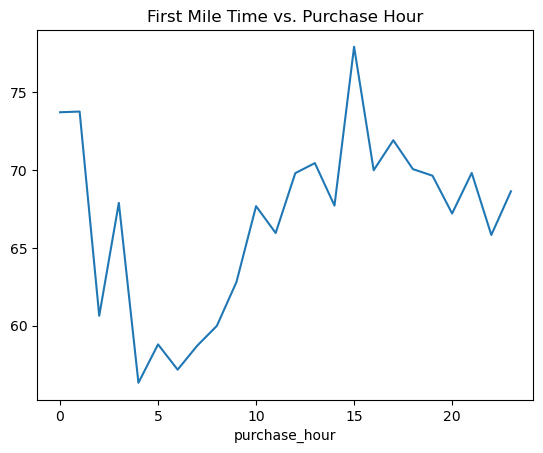

In [ ]:


final_df['first_mile_hours']=(
		(final_df['order_delivered_carrier_date']-final_df['order_approved_at']).dt.total_seconds() / 3600
	)

final_df['purchase_hour'] = final_df['order_purchase_timestamp'].dt.hour
urgency_analysis = final_df.groupby('purchase_hour')['first_mile_hours'].mean()
print("\n--- Average First Mile Time by Purchase Hour ---")
urgency_analysis.plot(title='First Mile Time vs. Purchase Hour')

#### Review Bombing Proxy

In [52]:
final_df['review_date'] = final_df['order_delivered_customer_date'].dt.date
bad_reviews = final_df[final_df['review_score'] == 1]
review_bombs = bad_reviews.groupby(['product_id', 'review_date']).size().reset_index(name='count')
print("\n--- Potential Review Bombing Incidents (High Volume of 1-Star Reviews on a Single Day) ---")
print(review_bombs.sort_values(by='count', ascending=False).head())


--- Potential Review Bombing Incidents (High Volume of 1-Star Reviews on a Single Day) ---
                            product_id review_date  count
8203  d2085f7e0f9533605386960fc7e987ec  2018-01-16   6876
2643  422879e10f46682990de24d770e7f83d  2017-12-28   6706
9326  eea3e07f864a0a1389726d8a5f31c3f6  2017-11-30   4752
8208  d22bbc02259111e107ee7916637d4791  2018-03-16   4284
4696  777d2e438a1b645f3aec9bd57e92672c  2017-05-24   4218


#### Cross-Border Commerce

In [53]:
def get_region(state):
    if state in ['SP', 'RJ', 'ES', 'MG']: return 'Southeast'
    if state in ['RS', 'SC', 'PR']: return 'South'
    if state in ['BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA']: return 'Northeast'
    return 'Other'
final_df['seller_region'] = final_df['seller_state'].apply(get_region)
final_df['customer_region'] = final_df['customer_state'].apply(get_region)
cross_region_performance = final_df[final_df['seller_region'] != final_df['customer_region']].groupby(['seller_region', 'customer_region'])['is_late'].mean()
print("\n--- Late Rate for Cross-Region Shipments ---")
print(cross_region_performance.sort_values(ascending=False))


--- Late Rate for Cross-Region Shipments ---
seller_region  customer_region
Southeast      Northeast          0.140044
Northeast      South              0.136847
South          Northeast          0.135135
Other          Northeast          0.112410
Southeast      Other              0.085754
Northeast      Other              0.080692
               Southeast          0.070707
Southeast      South              0.070405
South          Southeast          0.058027
Other          South              0.057045
South          Other              0.049951
Other          Southeast          0.041700
Name: is_late, dtype: float64


#### "Shipment Consolidation" Opportunity

In [ ]:
final_df['purchase_date'] = final_df['order_purchase_timestamp'].dt.date
daily_orders_per_customer = final_df.groupby(['customer_unique_id', 'purchase_date']).size()
consolidation_opps = daily_orders_per_customer[daily_orders_per_customer > 1]
print(f"\nFound {len(consolidation_opps)} instances where a customer placed multiple orders on the same day.")


Found 93199 instances where a customer placed multiple orders on the same day.


#### "Long-tail" Seller Contribution

In [ ]:
seller_revenue = final_df.groupby('seller_id')['revenue'].sum().sort_values()
bottom_80_percent_sellers = seller_revenue.head(int(len(seller_revenue) * 0.8))
long_tail_revenue = bottom_80_percent_sellers.sum()
total_revenue = final_df['revenue'].sum()
long_tail_contribution = (long_tail_revenue / total_revenue) * 100
print(f"\nThe bottom 80% of sellers contribute {long_tail_contribution:.2f}% of the total revenue.")


The bottom 80% of sellers contribute 17.89% of the total revenue.


#### Perfect Route Identification

In [57]:

final_df['is_perfect_order'] = (
    (final_df['proc_time'] <= 2) &
    (final_df['is_late'] == 0) &
    (final_df['review_score'] == 5)
    )
perfect_route = final_df.groupby('shipping_route')['is_perfect_order'].mean().sort_values(ascending=False)
print("\n--- Top 5 'Perfect Routes' by Performance ---")
print(perfect_route.head())


--- Top 5 'Perfect Routes' by Performance ---
shipping_route
ibitinga, SP → itanhanga, MT                 1.0
ibitinga, SP → brasil novo, PA               1.0
ibitinga, SP → boa viagem, CE                1.0
ibitinga, SP → boa vista da aparecida, PR    1.0
ibitinga, SP → bocaiuva do sul, PR           1.0
Name: is_perfect_order, dtype: float64
